2024-01-24 14:19:01,441:WARNING:CUDA is available. Using GPU instead.


cuda


/home/humboldt/.conda/envs/matsuo-koyamatsu-py310/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-01-24 14:19:02,936:INFO:Start preprocessing.
2024-01-24 14:19:14,488:INFO:Finish preprocessing. Data size is 91


valid_dataset 91
week_reports torch.Size([2, 320])
week_reports torch.Size([2, 320])
week_reports torch.Size([2, 320])
week_reports torch.Size([2, 320])
epoch: 0
week_reports torch.Size([2, 320])
week_reports torch.Size([2, 320])
week_reports torch.Size([2, 320])
week_reports torch.Size([2, 320])
epoch: 1
week_reports torch.Size([2, 320])
week_reports torch.Size([2, 320])
week_reports torch.Size([2, 320])
week_reports torch.Size([2, 320])
epoch: 2
week_reports torch.Size([2, 320])
week_reports torch.Size([2, 320])
week_reports torch.Size([2, 320])
week_reports torch.Size([2, 320])
epoch: 3
week_reports torch.Size([2, 320])
week_reports torch.Size([2, 320])
week_reports torch.Size([2, 320])
week_reports torch.Size([2, 320])
epoch: 4
week_reports torch.Size([2, 320])
week_reports torch.Size([2, 320])
week_reports torch.Size([2, 320])
week_reports torch.Size([2, 320])
epoch: 5
week_reports torch.Size([2, 320])
week_reports torch.Size([2, 320])
week_reports torch.Size([2, 320])
week_report

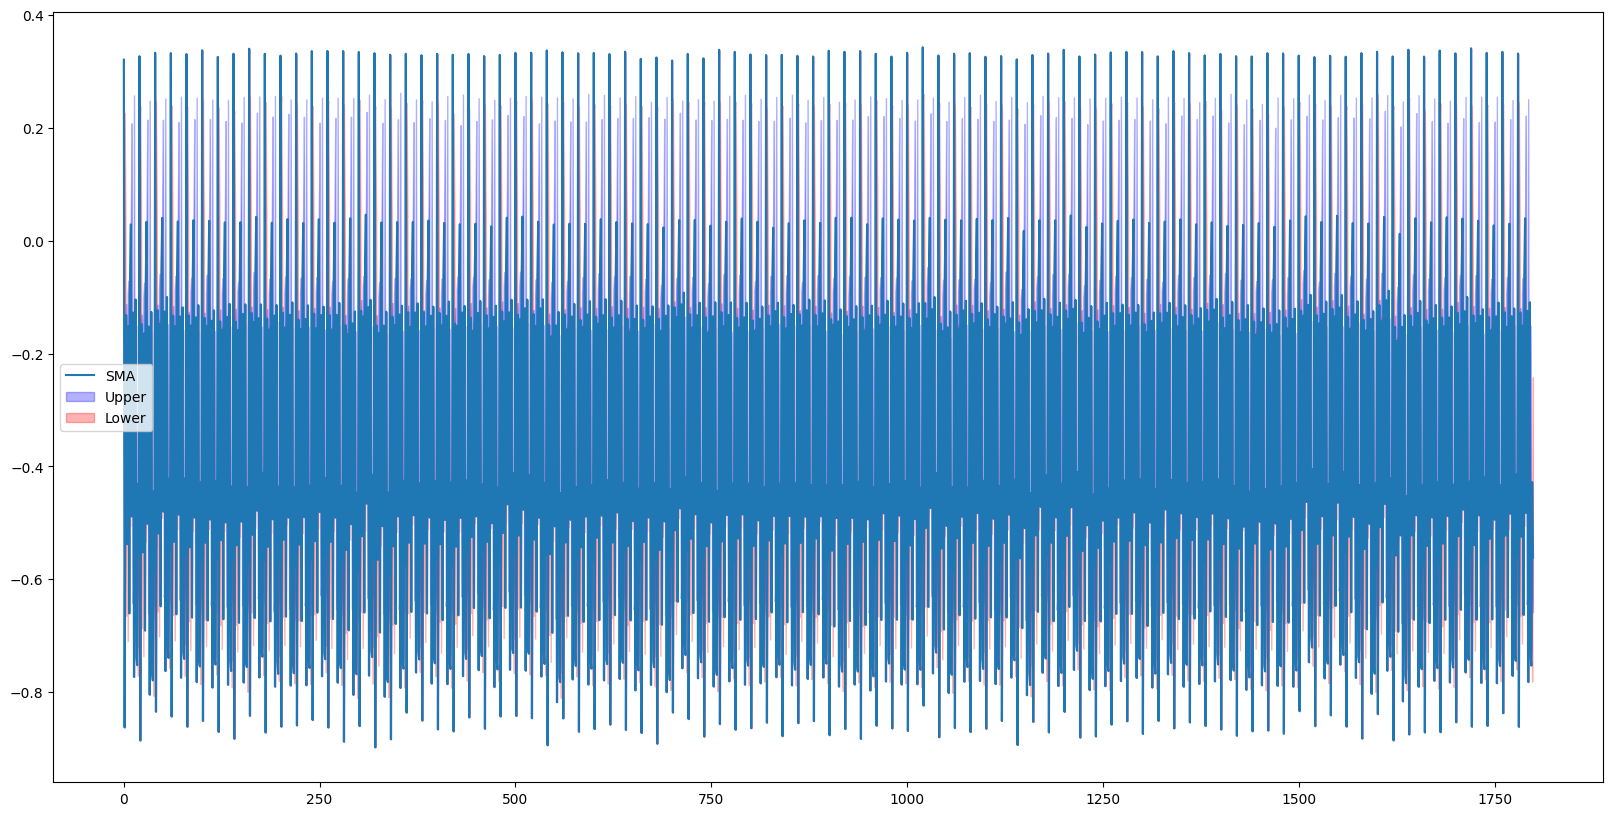

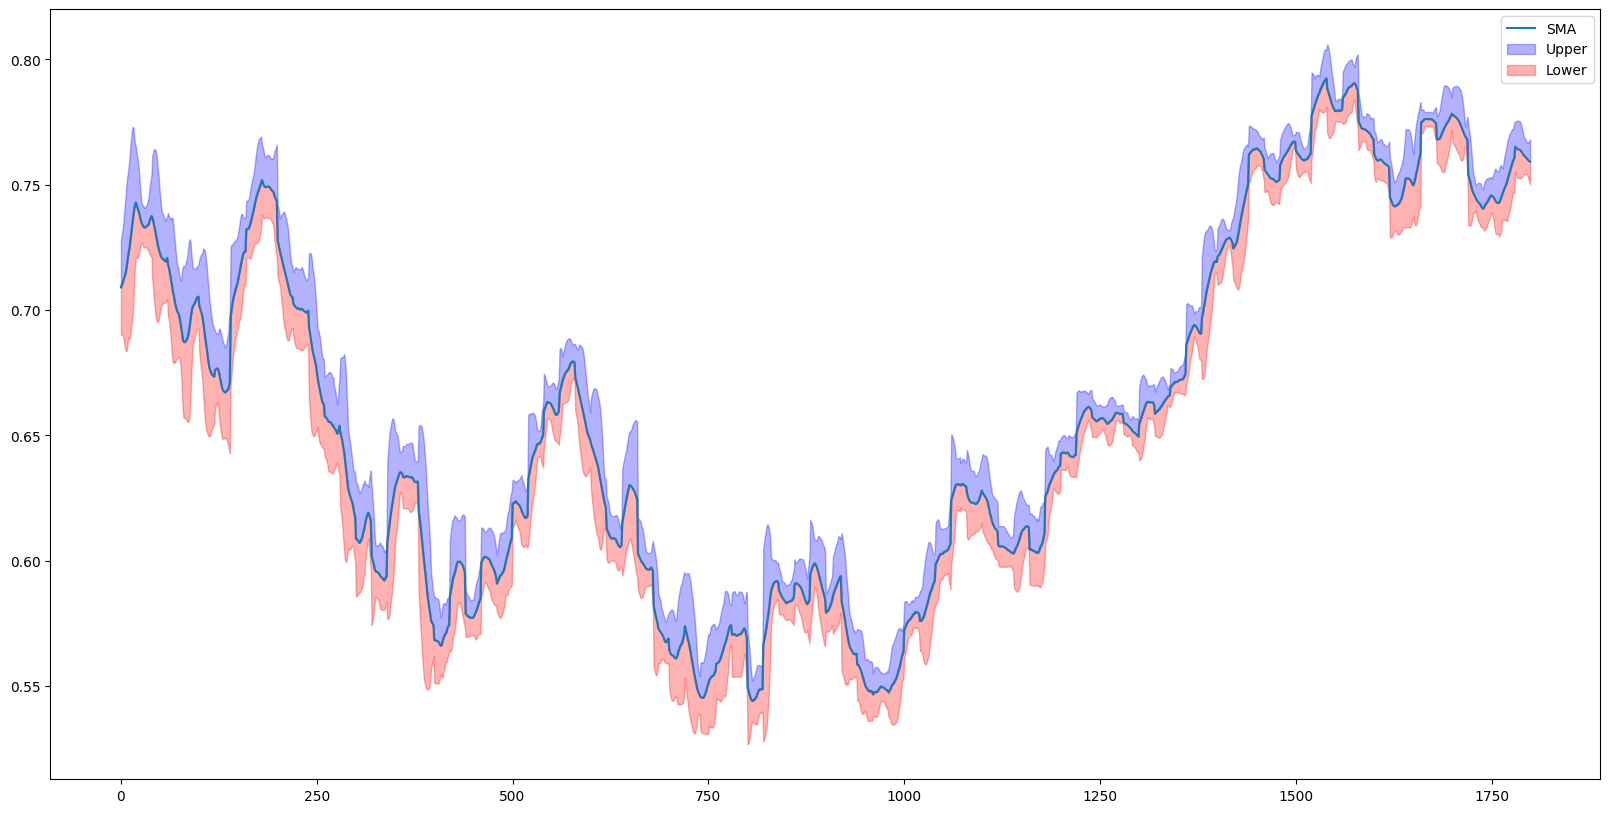

In [49]:
# coding: utf-8
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import logging
import os
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from ml.text.bert import BERT_Report
from transformers import BertModel, BertTokenizer
from ml.price.transfomer import TransformerModelWithPositionalEncoding

torch.autograd.set_detect_anomaly(True)

# モデルのパラメータを設定
batch_size = 2
price_feature_dim = 11
hidden_size = 512
price_output_size = 256
nhead = 8
num_encoder_layers = 3
dim_feedforward = 2048
learning_epoch_num = 1000

# modelディレクトリの作成
os.makedirs("model", exist_ok=True)

# GPU利用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# 現在の日時を取得し、フォルダ名用にフォーマット
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
log_directory = f"logs/{current_time}"

# ログを保存するディレクトリを作成
os.makedirs(log_directory, exist_ok=True)

# ログファイルの設定
log_file = os.path.join(log_directory, "logfile.log")

# ロガーの設定
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s:%(levelname)s:%(message)s',
    handlers=[
        logging.FileHandler(log_file),  # ファイルハンドラー
        logging.StreamHandler()         # ストリーム（コンソール）ハンドラ
    ])

# デバイスがCUDAでない場合は警告を出す
if device.type != 'cuda':
    logging.error('CUDA is not available. Using CPU instead.')
else :
    logging.warning('CUDA is available. Using GPU instead.')

writer: SummaryWriter = SummaryWriter(
    log_dir=log_directory
)  

# 事前学習済みモデルのロード
bert = BertModel.from_pretrained('bert-base-uncased')
# tokenizer インスタンスの生成
# 対象モデルは'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# モデルインスタンスの生成
one_report_dim = 64

bert_model = BERT_Report(bert, one_report_dim, tokenizer).to(device)
param_bert_num = 0

# モデルのインスタンス化
transformer_model_with_attention = TransformerModelWithPositionalEncoding(price_feature_dim, hidden_size, price_output_size, nhead, num_encoder_layers, dim_feedforward).to(device)

from ml.text.text_concatenate import TEXT_Cconcatenate
all_reports_dim = one_report_dim * 5
all_reports_out_dim = 128
text_cconcatenate = TEXT_Cconcatenate(all_reports_dim, all_reports_out_dim).to(device)

# Generator
from ml.gan.generator import Generator
generator   = Generator().to(device)


# RMSE損失関数を定義
def rmse_loss(input, target):
    return torch.sqrt(torch.mean((input - target) ** 2))

# データ読み込み
data = pd.read_pickle('data/sentiment_stock_data.pkl')
#train_data = data[data.index < '2022-01-03']
valid_data = data[data.index >= '2022-01-03']

# FinancialDataset クラスのインポート
from data.data_loder import FinancialDataset
#train_dataset = FinancialDataset(train_data, week_len=4, target_len=80)
valid_dataset = FinancialDataset(valid_data, week_len=4, target_len=80)
print("valid_dataset", len(valid_dataset))

# # DataLoader を使用してデータセットをロード
#train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True, collate_fn=valid_dataset.collate_fn)

# エポック全体の損失を格納するリスト

max_grad_norm = 1.0  # 勾配の最大ノルム

# モデルのロード
bert_model.load_state_dict(torch.load("model/bert_model_70.pth"))
transformer_model_with_attention.load_state_dict(torch.load("model/transformer_model_with_attention_70.pth"))
text_cconcatenate.load_state_dict(torch.load("model/text_cconcatenate_70.pth"))
generator.load_state_dict(torch.load("model/generator_70.pth"))

# 評価
with torch.no_grad():
    predictions_list = []
    target_list = []
    for j, x in enumerate(valid_dataloader):
        week = x[0].shape[1]
        num = x[0].shape[2]
        b = x[0].shape[0]
        prices = x[0].reshape(b, week*num, price_feature_dim).to(device)
        # 教師データをGPUに転送
        target = x[2].to(device)  # 教師データ
        #print("target", target.shape)

        #print("prices" , prices.shape)
        latent_vector, attention_weights = transformer_model_with_attention(prices)
        #print("latent_vector" , latent_vector.shape)

        text = x[1].to(device)
        region_num = text.shape[2]
        #print("region" , region_num)
        all_reports = None
        for w in range(week):
            tex_latent_regions =[]
            for r in range(region_num):
                text_region = text[:,w, r ].reshape(b, 500)
                # text_region = text[0,w, r ].reshape(850)
                #print("text_region" , text_region.shape)
                tex_latent = bert_model(text_region)
                #print("tex_latent" , tex_latent.shape)
                # もしtex_latentの次元が1なら、unsqueezeで次元を追加
                tex_latent_regions.append(tex_latent)
            week_reports = torch.cat( [tex_latent_regions[0],tex_latent_regions[1],tex_latent_regions[2],tex_latent_regions[3],tex_latent_regions[4]]  , dim=1)
            print("week_reports" , week_reports.shape)

            # Text concat
            week_report = text_cconcatenate(week_reports)
            #print("Week_report", week_report.shape)
            if all_reports == None:
                all_reports = week_report
            else:
                all_reports = torch.cat([all_reports, week_report], dim=1)#all_reports.append(week_reports)
        #print("all_reports", all_reports.shape)

        # all_reportsとPriceのLatentをCat
        all_reports_latent = torch.cat( [all_reports, latent_vector] , dim=1)
        #print("all_reports_latent", all_reports_latent.shape)

        # Generatorに入力
        predictions = generator(all_reports_latent)
        
        # print(target.shape) # (2, 20, 3)
        # print(predictions.shape) # (2, 20, 3)
        
        # PredictionsとTargetを格納
        predictions_list.append(predictions.detach().cpu())
        target_list.append(target.detach().cpu())
        print("epoch:", j)

# PredictionsとTargetを結合
predictions = torch.cat(predictions_list, dim=0)
target = torch.cat(target_list, dim=0)
print("predictions", predictions.shape)
print("target", target.shape)

# RMSEを計算
rmse = torch.sqrt(torch.mean((predictions - target) ** 2))
print("RMSE", rmse)

# 予測結果をプロット
from util import plot_target
fig1 = plot_target(predictions)
fig2 = plot_target(target)

fig1.savefig("output/Estimated.png")
fig2.savefig("output/Real.png")

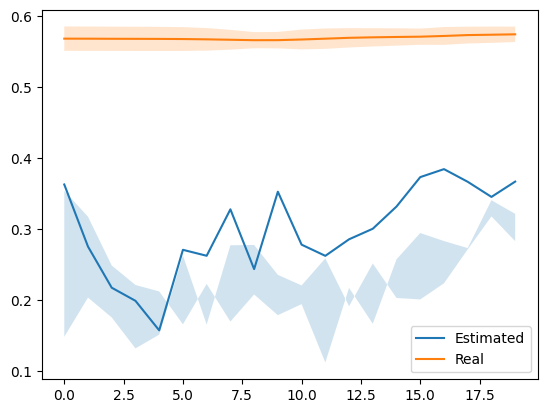

In [47]:
i = 20
sma_estim, upper_estim, lower_estim = predictions[i, :, 0].detach().cpu().numpy(), predictions[i, :, 1].detach().cpu().numpy(), predictions[i, :, 2].detach().cpu().numpy()
sma_real, upper_real, lower_real = target[i, :, 0].detach().cpu().numpy(), target[i, :, 1].detach().cpu().numpy(), target[i, :, 2].detach().cpu().numpy()
# 結合
plt.plot(sma_estim, label="Estimated")
plt.fill_between(range(len(sma_estim)), upper_estim, lower_estim, alpha=0.2)
plt.plot(sma_real, label="Real")
plt.fill_between(range(len(sma_real)), upper_real, lower_real, alpha=0.2)
plt.legend()

2904


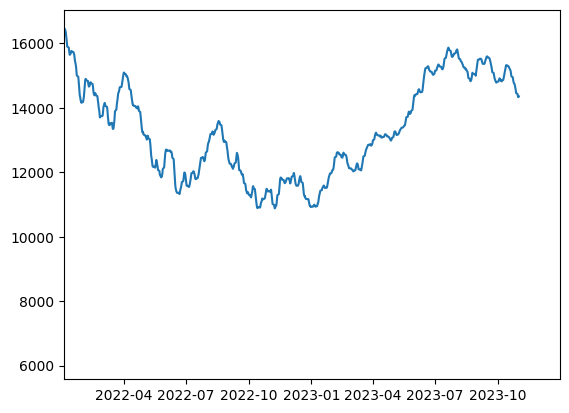

In [35]:
import datetime as dt
df_data = pd.read_pickle('data/sentiment_stock_data.pkl')
plt.plot(df_data["20SMA"])
plt.xlim(dt.datetime(2022,1,3), dt.datetime(2023,12,31))

# この期間のデータ数
print(len(df_data[df_data.index > '2022-01-03']))

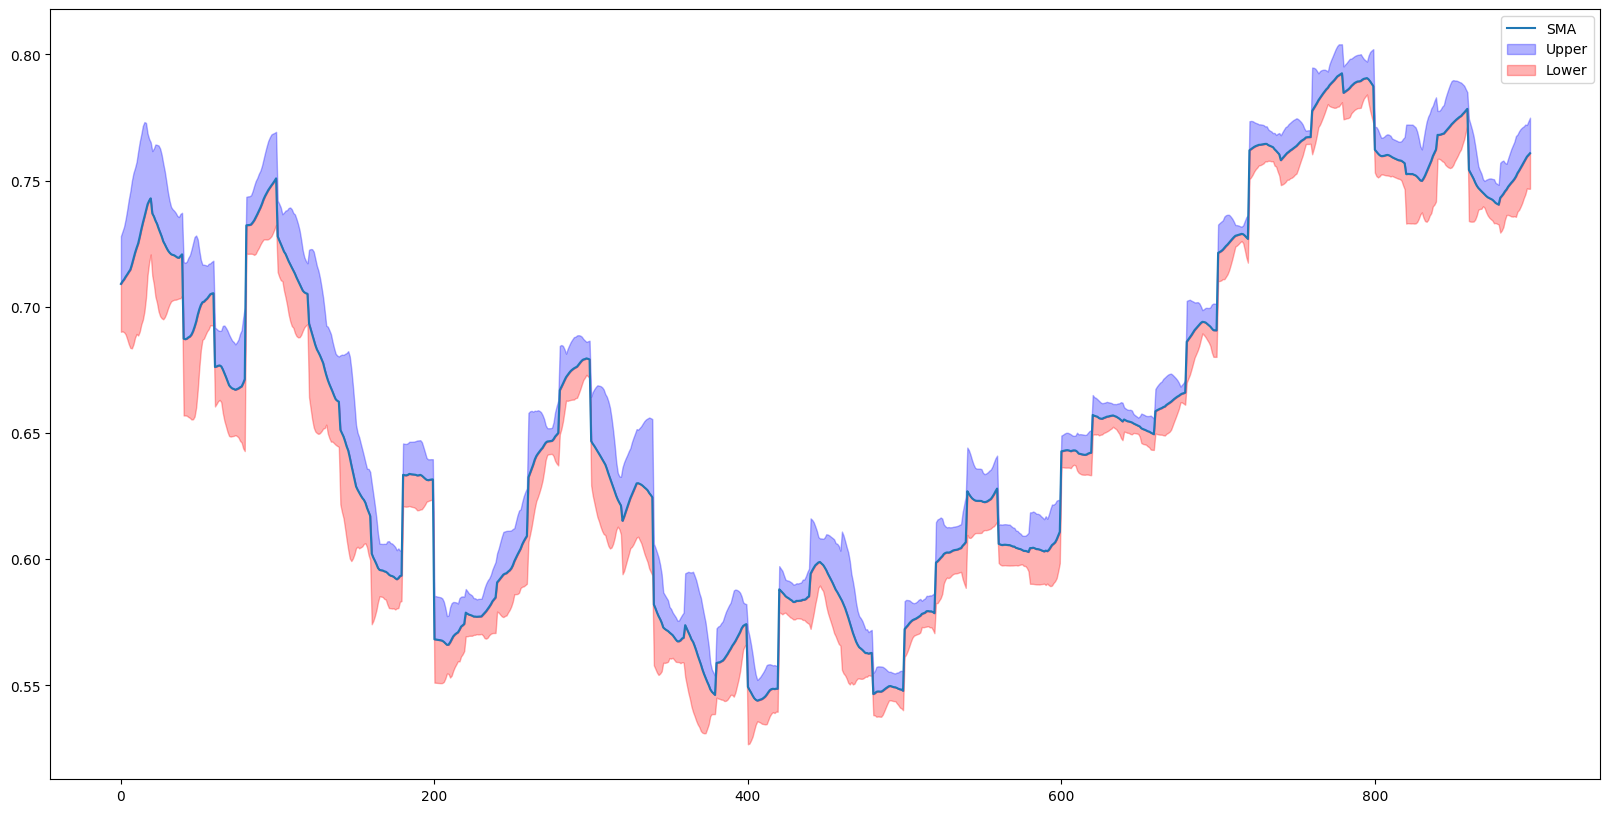

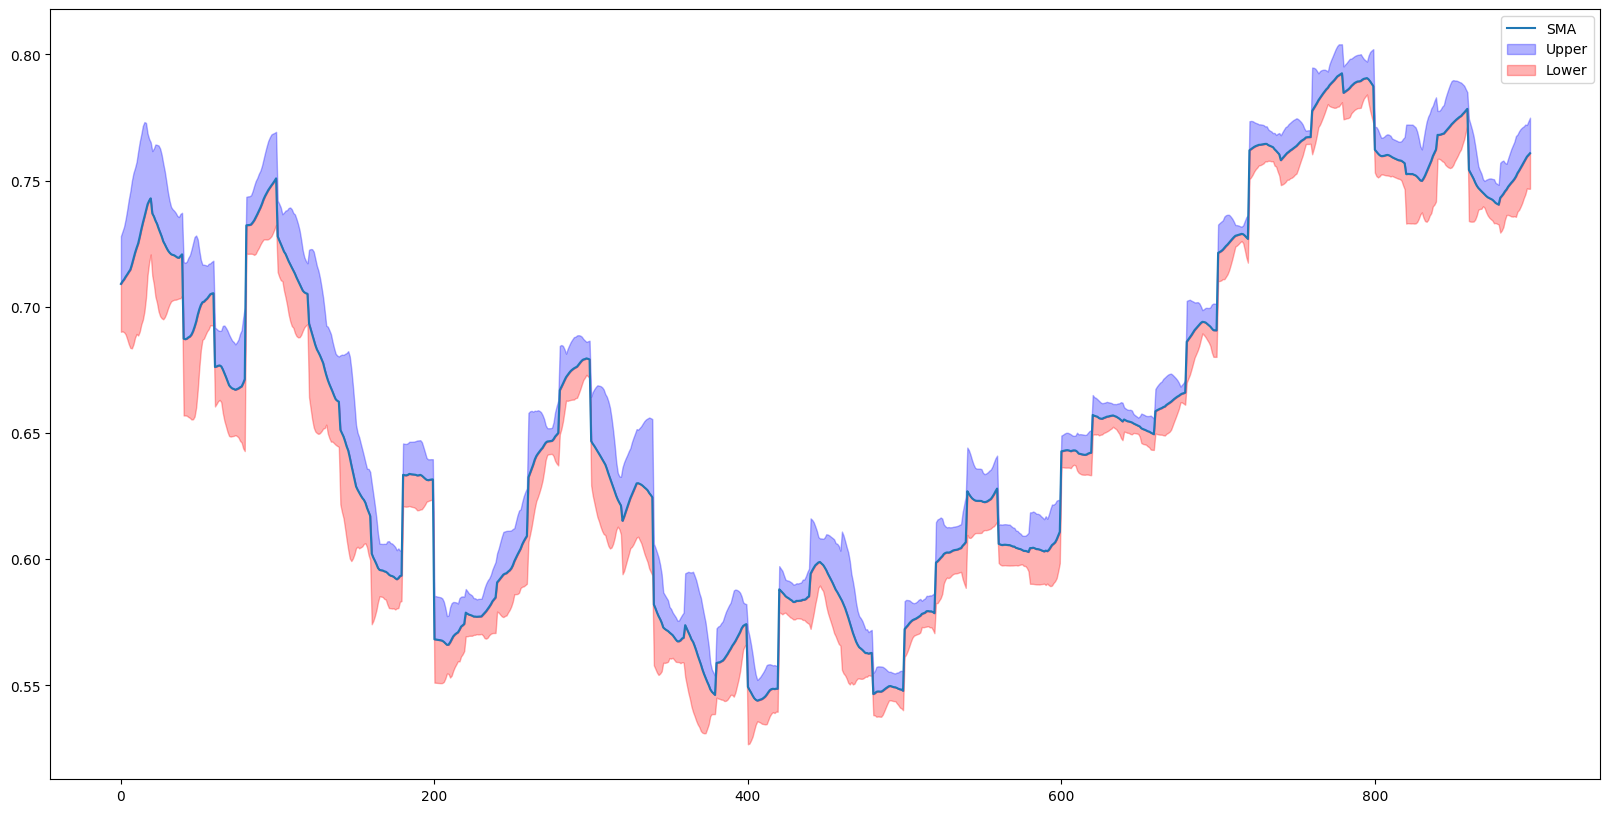

In [32]:
# targetから2バッチ置きにデータを取得
target_2 = target[::2]
target_2.shape

# 予測結果をプロット
plot_target(target_2)